In [24]:

import glob
import os

import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math

from neuroformer.model_neuroformer_2 import GPT, GPTConfig, load_model_and_tokenizer
from neuroformer.utils import get_attr
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils_2 import (set_seed, update_object, running_jupyter, 
                                 all_device, load_config, 
                                 dict_to_object, object_to_dict, recursive_print,
                                 create_modalities_dict, generate_spikes)
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import make_intervals, round_n, SpikeTimeVidData2
from neuroformer.DataUtils import round_n, split_data_by_interval, Tokenizer
from neuroformer.datasets import load_visnav, load_V1AL

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

import argparse
import wandb

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

from neuroformer.default_args import DefaultArgs, parse_args

if running_jupyter(): # or __name__ == "__main__":
    print("Running in Jupyter")
    args = DefaultArgs()
    # args.dataset = "medial"
    # args.ckpt_path = "./models/NF.15/Visnav_VR_Expt/medial/Neuroformer/predict_all_behavior/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25"
    
    args.dataset = "lateral"
    args.ckpt_path = "./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/pos_emb/Neuroformer/1_new/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25"
    args.predict_modes = ['speed', 'phi', 'th']
    args.finetuning_config = "finetuning_config.yaml"
else:
    print("Running in terminal")
    args = parse_args()


# SET SEED - VERY IMPORTANT
set_seed(args.seed)

print(f"CONTRASTIUVEEEEEEE {args.contrastive}")
print(f"VISUAL: {args.visual}")
print(f"PAST_STATE: {args.past_state}")


config, tokenizer, model = load_model_and_tokenizer(args.ckpt_path)

Running in Jupyter
CONTRASTIUVEEEEEEE False
VISUAL: True
PAST_STATE: True
256 2203


10/15/2023 15:09:23 - INFO - neuroformer.model_neuroformer_2 -   number of parameters: 2.877057e+07


 ///// <=----- Loading model from ./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/pos_emb/Neuroformer/1_new/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25 -----=> \\\


In [12]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing

"""
print(f"DATASET: {args.dataset}")
if args.dataset in ["lateral", "medial"]:
    data, intervals, train_intervals, \
    test_intervals, finetune_intervals, \
    callback = load_visnav(args.dataset, config, 
                           selection=config.selection if hasattr(config, "selection") else None)
elif args.dataset == "V1AL":
    data, intervals, train_intervals, \
    test_intervals, finetune_intervals, \
    callback = load_V1AL(config)

spikes = data['spikes']
stimulus = data['stimulus']

DATASET: lateral


In [13]:
window = config.window.curr
window_prev = config.window.prev
dt = config.resolution.dt


# -------- #

spikes_dict = {
    "ID": data['spikes'],
    "Frames": data['stimulus'],
    "Interval": intervals,
    "dt": config.resolution.dt,
    "id_block_size": config.block_size.id,
    "prev_id_block_size": config.block_size.prev_id,
    "frame_block_size": config.block_size.frame,
    "window": config.window.curr,
    "window_prev": config.window.prev,
    "frame_window": config.window.frame,
}

frames = {'feats': stimulus, 'callback': callback, 'window': config.window.frame, 'dt': config.resolution.dt}


""" structure:
{
    type_of_modality:
        {name of modality: {'data':data, 'dt': dt, 'predict': True/False},
        ...
        }
    ...
}
"""



" structure:\n{\n    type_of_modality:\n        {name of modality: {'data':data, 'dt': dt, 'predict': True/False},\n        ...\n        }\n    ...\n}\n"

In [28]:
import yaml

# now instantiate a new, updated dict with the new modalities
new_config = yaml.load(os.path.join(args.ckpt_path, args.finetuning_config), Loader=yaml.FullLoader)
model = GPTConfig(new_config)

# load previous model weights, ignoring potentially new added weights
model.load_state_dict(torch.load(os.path.join(args.ckpt_path, "model.pt")), strict=False)

TypeError: __init__() missing 1 required positional argument: 'block_size'

'./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/pos_emb/Neuroformer/1_new/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25/finetuning_config.yaml'

In [15]:
# update model
model = model(config)

from neuroformer.DataUtils import NFDataloader

# choose finetuning set
finetune_dataset = NFDataloader(spikes_dict, tokenizer, config, dataset=args.dataset, 
                                frames=frames, intervals=finetune_intervals, modalities=modalities)

# Create a DataLoader
loader = DataLoader(finetune_dataset, batch_size=2, shuffle=True, num_workers=0)
iterable = iter(loader)
x, y = next(iterable)
recursive_print(y)
preds, features, loss = model(x, y)

# Set training parameters
MAX_EPOCHS = 300
BATCH_SIZE = 32 * 5
SHUFFLE = True

if config.gru_only:
    model_name = "GRU"
elif config.mlp_only:
    model_name = "MLP"
elif config.gru2_only:
    model_name = "GRU_2.0"
else:
    model_name = "Neuroformer"

# CKPT_PATH = f"/share/edc/home/antonis/neuroformer/models/NF.15/Visnav_VR_Expt/{DATASET}/{model_name}/1_new/{str(config.layers)}/{str(config.window)}/{SEED}"
# CKPT_PATH = CKPT_PATH.replace("namespace", "").replace(" ", "_")
CKPT_PATH = args.ckpt_path

# Define the parameters
sample = True
top_p = 0.95
top_p_t = 0.95
temp = 1.
temp_t = 1.
frame_end = 0
true_past = args.true_past
get_dt = True
gpu = True
pred_dt = True

# # Run the prediction function
# results_trial = generate_spikes(model, test_dataset, window, 
#                                 window_prev, tokenizer, 
#                                 sample=sample, top_p=top_p, top_p_t=top_p_t, 
#                                 temp=temp, temp_t=temp_t, frame_end=frame_end, 
#                                 true_past=true_past,
#                                 get_dt=get_dt, gpu=gpu, pred_dt=pred_dt,
#                                 plot_probs=False)

# # Create a filename string with the parameters
# filename = f"results_trial_sample-{sample}_top_p-{top_p}_top_p_t-{top_p_t}_temp-{temp}_temp_t-{temp_t}_frame_end-{frame_end}_true_past-{true_past}_get_dt-{get_dt}_gpu-{gpu}_pred_dt-{pred_dt}.pkl"

# # Save the results in a pickle file
# save_inference_path = os.path.join(CKPT_PATH, "inference")
# if not os.path.exists(save_inference_path):
#     os.makedirs(save_inference_path)

# print(f"Saving inference results in {os.path.join(save_inference_path, filename)}")

# with open(os.path.join(save_inference_path, filename), "wb") as f:
#     pickle.dump(results_trial, f)


Min Interval: 0.1
Intervals:  12046
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  2203
Using explicitly passed intervals
Min Interval: 0.1
Intervals:  12046
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  2203
Using explicitly passed intervals
Min Interval: 0.1
Intervals:  120
Window:  0.05
Window Prev:  0.05
Population Size:  2026
ID Population Size:  2026
DT Population Size:  2203
Using explicitly passed intervals
id_prev torch.Size([700]) torch.int64
dt_prev torch.Size([700]) torch.float32
pad_prev torch.Size([]) torch.int64
id torch.Size([100]) torch.int64
dt torch.Size([100]) torch.float32
pad torch.Size([]) torch.int64
interval torch.Size([]) torch.float32
trial torch.Size([]) torch.int64
modalities_behavior_phi_value torch.Size([1, 1]) torch.float32
modalities_behavior_phi_dt torch.Size([1]) torch.float32
modalities_behavior_th_value torch.Size([1, 1]) torch.float32
mo

In [14]:
# predict other modality
from neuroformer.utils_2 import predict_modality
# model.load_state_dict(torch.load(os.path.join(CKPT_PATH, f"_epoch_speed.pt"), map_location=torch.device('cpu')))
model.load_state_dict(torch.load(os.path.join(CKPT_PATH, f"model.pt"), map_location=torch.device('cpu')))
args.predict_modes = ['speed', 'phi', 'th']
behavior_preds = {}
if args.predict_modes is not None:
    block_type = 'behavior'
    block_config = get_attr(config.modalities, block_type).variables
    for mode in args.predict_modes:
        mode_config = get_attr(block_config, mode)
        behavior_preds[mode] = predict_modality(model, test_dataset, modality=mode, 
                                          block_type=block_type, objective=get_attr(mode_config, 'objective'))
        # filename = f"behavior_preds_{mode}.csv"
        # save_inference_path = os.path.join(CKPT_PATH, "inference")
        # if not os.path.exists(save_inference_path):
        #     os.makedirs(save_inference_path)
        # print(f"Saving inference results in {os.path.join(save_inference_path, filename)}")
        # behavior_preds.to_csv(os.path.join(save_inference_path, filename))

100%|██████████| 482/482 [09:01<00:00,  1.12s/it]


In [11]:
from scipy.stats import pearsonr
# from neuroformer.visualize import set_plot_params
# from neuroformer.visualize import set_research_params
model_name = "nf_1.5"



x_true, y_true = behavior_preds['cum_interval'], behavior_preds['true']
x_pred, y_pred = behavior_preds['cum_interval'], behavior_preds[f'behavior_{mode}_value']

# pearson r
r, p = pearsonr([float(y) for y in y_pred], [float(y) for y in y_true])

# plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_true, y_pred, s=100, c='k', alpha=0.5)

# get the current axis limits after plotting your data
xlims = ax.get_xlim()
ylims = ax.get_ylim()
s_f = 0.8
# the line of perfect prediction should span the minimum to the maximum of the current x and y limits
combined_limits = [min(xlims[0], ylims[0]) * s_f, max(xlims[1], ylims[1]) * s_f]
ax.plot(combined_limits, combined_limits, 'k--', color='red')

ax.set_xlabel(f'True {mode}', fontsize=20)
ax.set_ylabel(f'Predicted {mode}', fontsize=20)
ax.set_title(f'{model_name}, Regression', fontsize=20)
# add pearson r to figure
ax.text(0.05, 0.9, 'r = {:.2f}'.format(r), fontsize=20, transform=ax.transAxes)
# add p to figure
ax.text(0.05, 0.8, 'p < 0.001'.format(p), fontsize=20, transform=ax.transAxes)

# axis limits = [-1.5, 1.5]
# ax.set_xlim(axis_limits)
# ax.set_ylim(axis_limits)
plt.savefig(os.path.join(args.ckpt_path, 'regression_2.pdf'), dpi=300, bbox_inches='tight')


# # plot
# fig, ax = plt.subplots(figsize=(2.5, 2.5))
# ax.scatter(y_true, y_pred, c='k', alpha=0.5)

# # get the current axis limits after plotting your data
# xlims = ax.get_xlim()
# ylims = ax.get_ylim()
# s_f = 0.8
# # the line of perfect prediction should span the minimum to the maximum of the current x and y limits
# combined_limits = [min(xlims[0], ylims[0]) * s_f, max(xlims[1], ylims[1]) * s_f]
# ax.plot(combined_limits, combined_limits, 'k--', color='red')

# ax.set_xlabel(f'True {mode}',)
# ax.set_ylabel(f'Predicted {mode}',)
# ax.set_title(f'{model_name}, Regression',)
# # add pearson r to figure
# ax.text(0.05, 0.9, 'r = {:.2f}'.format(r), transform=ax.transAxes)
# # add p to figure
# ax.text(0.05, 0.8, 'p < 0.001'.format(p), transform=ax.transAxes)

# # axis limits = [-1.5, 1.5]
# # ax.set_xlim(axis_limits)
# # ax.set_ylim(axis_limits)
# plt.savefig(os.path.join(args.ckpt_path, 'regression_2.pdf'), dpi=300, bbox_inches='tight')


# %%
# plt.figure(figsize=(5, 2.5))
# x = np.arange(len(behavior_preds))
# plt.title(f'{mode} Predictions, {model_name} Regression vs. True')
# plt.plot(x, y_true, c='r', label='True')
# plt.plot(x, y_pred, c='b', label='Regression')
# plt.xlabel('Time (0.05s)')
# plt.ylabel('mode (z-scored)')
# plt.legend(loc='upper left', framealpha=0.9)
# plt.savefig(os.path.join(args.ckpt_path, 'mode_preds.pdf'), bbox_inches='tight')


# plt.figure(figsize=(10, 5))
# x = np.arange(len(behavior_preds))
# plt.title(f'{mode} Predictions, {model_name} Regression vs. True')
# plt.plot(x, y_true, c='r', label='True')
# plt.plot(x, y_pred, c='b', label='Regression')
# plt.xlabel('Time (0.05s)')
# plt.ylabel('mode (z-scored)')
# plt.legend(loc='upper left', framealpha=0.9)

KeyError: 'cum_interval'

In [12]:
def plot_regression(y_true, y_pred, mode, model_name, r, p, 
                    ax=None, axis_limits=None, save_path=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    ax.scatter(y_true, y_pred, s=100, c='k', alpha=0.5)

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    s_f = 0.8
    combined_limits = [min(xlims[0], ylims[0]) * s_f, max(xlims[1], ylims[1]) * s_f]
    ax.plot(combined_limits, combined_limits, 'k--', color='red')

    ax.set_xlabel(f'True {mode}', fontsize=20)
    ax.set_ylabel(f'Predicted {mode}', fontsize=20)
    ax.set_title(f'{model_name}, Regression', fontsize=20)
    ax.text(0.05, 0.9, 'r = {:.2f}'.format(r), fontsize=20, transform=ax.transAxes)
    ax.text(0.05, 0.8, 'p < 0.001'.format(p), fontsize=20, transform=ax.transAxes)

    if axis_limits is not None:
        ax.set_xlim(axis_limits)
        ax.set_ylim(axis_limits)

    if save_path:
        plt.savefig(os.path.join(save_path, 'regression_2.pdf'), dpi=300, bbox_inches='tight')

/tmp/ipykernel_2555887/1818825069.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='red')
/tmp/ipykernel_2555887/1818825069.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='red')
/tmp/ipykernel_2555887/1818825069.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='red')


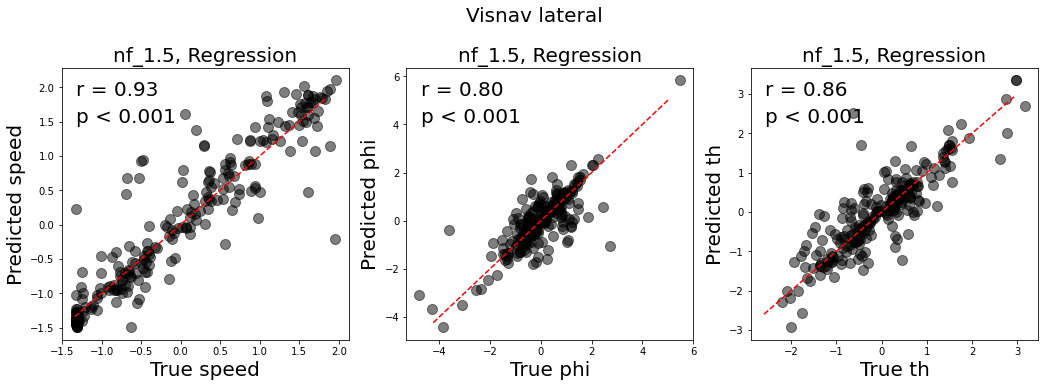

In [13]:
fig, ax = plt.subplots(figsize=(17.5, 5), nrows=1, ncols=len(args.predict_modes))
plt.suptitle(f'Visnav {args.dataset}', fontsize=20, y=1.05)
for n, mode in enumerate(args.predict_modes):
    behavior_preds_mode = behavior_preds[mode]
    x_true, y_true = behavior_preds_mode['cum_interval'], behavior_preds_mode['true']
    x_pred, y_pred = behavior_preds_mode['cum_interval'], behavior_preds_mode[f'behavior_{mode}_value']
    r, p = pearsonr([float(y) for y in y_pred], [float(y) for y in y_true])
    axis = ax[n]
    plot_regression(y_true, y_pred, mode, model_name, r, p, ax=axis, save_path=args.ckpt_path)